In [7]:
import pandas as pd
import requests
import datetime
import json

In [270]:
df = []
comments = []

headers = {'Authorization': 'token %s' % 'TOKEN'}

# Get data from JOSS

In [148]:
# let's look for the first 1000 closed issues 

for i in range(1,11):
    closed_issues = requests.get(f'https://api.github.com/repos/openjournals/joss-reviews/issues?state=closed&per_page=100&page={i}', headers=headers)
    closed_issues = closed_issues.json()
    
    for issue in closed_issues:
        #extract basic info about the submission
        
        assignees = len(issue['assignees'])
        created_at = datetime.datetime.strptime(issue['created_at'], '%Y-%m-%dT%H:%M:%SZ')
        closed_at = datetime.datetime.strptime(issue['closed_at'], '%Y-%m-%dT%H:%M:%SZ')
        res = closed_at - created_at
        comments_no = issue['comments']
        
        title = issue['title']
        if "[PRE REVIEW]" in title:
            status = "PRE REVIEW"
        elif "[REVIEW]" in title:
            status = "REVIEW"
        else:
            status = 0
        s = "closed"
        
        rejected = 0
        for l in issue['labels']:
            if 'rejected' in l['name']:
                rejected = 1
        
        df.append([status, s, rejected, assignees, res.days, created_at.year, comments_no])
        
        #extract comments for NLP analysis
        
        if rejected == 0: # exclude rejected submissions
            comments_req = requests.get(issue['comments_url'], headers=headers).json()
            for c in comments_req:
                comments.append([c['user']['login'], s, c['author_association'], c['body'], \
                                 c['reactions']['+1'], c['reactions']['-1'], \
                                 c['reactions']['laugh'], c['reactions']['hooray'], \
                                 c['reactions']['confused'], c['reactions']['heart'], \
                                 c['reactions']['rocket'], c['reactions']['eyes']])

In [149]:
len(df)

1000

In [150]:
len(comments)

21405

In [151]:
# same for 500 open issues
for i in range(1,11):
    closed_issues = requests.get(f'https://api.github.com/repos/openjournals/joss-reviews/issues?state=open&per_page=100&page={i}', headers=headers)
    closed_issues = closed_issues.json()
    
    for issue in closed_issues:
        #extract basic info about the submission
        
        assignees = len(issue['assignees'])
        created_at = datetime.datetime.strptime(issue['created_at'], '%Y-%m-%dT%H:%M:%SZ')
        today = datetime.datetime.now()
        res = today - created_at
        comments_no = issue['comments']
        
        title = issue['title']
        if "[PRE REVIEW]" in title:
            status = "PRE REVIEW"
        elif "[REVIEW]" in title:
            status = "REVIEW"
        else:
            status = 0
        s = "open"
        
        df.append([status, s, 0, assignees, res.days, created_at.year, comments_no])
        
        #extract comments for NLP analysis
        comments_req = requests.get(issue['comments_url'], headers=headers).json()
        for c in comments_req:
            comments.append([c['user']['login'], s, c['author_association'], c['body'], \
                             c['reactions']['+1'], c['reactions']['-1'], \
                             c['reactions']['laugh'], c['reactions']['hooray'], \
                             c['reactions']['confused'], c['reactions']['heart'], \
                             c['reactions']['rocket'], c['reactions']['eyes']])

In [152]:
len(df)

1182

In [153]:
len(comments)

25382

# Save data 

(because it takes long to retrieve)

In [154]:
# save basic info
df1 = pd.DataFrame(df, columns = [
    'review',  'status', 'rejected', 'reviewers', 'days_active', 'year', 'comments'])
df1.to_csv("issues.csv", index=False)

In [155]:
# save comments
df2 = pd.DataFrame(comments, columns = [
    'user', 'status','author_association', 'body', 'thumbs_up', 'thumbs_down', 'laugh', 'hooray', 'confused', 'heart', 'rocket', 'eyes'])

In [156]:
df2.to_csv("comments.csv", index=False)

# Submission basic info

In [157]:
df = pd.read_csv('issues.csv')

In [159]:
df.head()

,review,status,rejected,reviewers,days_active,year,comments
0,0,closed,0,0,0,2021,1
1,PRE REVIEW,closed,0,4,2,2021,32
2,PRE REVIEW,closed,0,0,0,2021,13
3,PRE REVIEW,closed,0,3,2,2021,26
4,0,closed,0,0,0,2021,1


In [160]:
df['rejected'].value_counts()

0    1003
1     179
Name: rejected, dtype: int64

In [161]:
df.dtypes

review         object
status         object
rejected        int64
reviewers       int64
days_active     int64
year            int64
comments        int64
dtype: object

In [162]:
len(df)

1182

In [165]:
# remove rejected from df

df = df[(df['rejected']==0)]

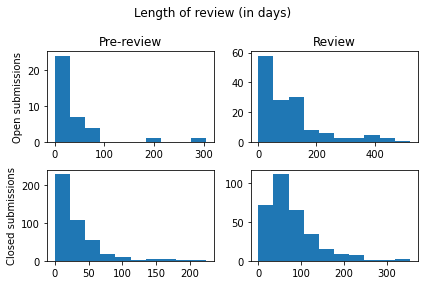

In [166]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(df[(df['status']=='open') & (df['review']=='PRE REVIEW')]['days_active'])
axs[0, 0].set_title('Pre-review')
axs[0, 1].hist(df[(df['status']=='open') & (df['review']=='REVIEW')]['days_active'])
axs[0, 1].set_title('Review')
axs[1, 0].hist(df[(df['status']=='closed') & (df['review']=='PRE REVIEW')]['days_active'])
axs[1, 1].hist(df[(df['status']=='closed') & (df['review']=='REVIEW')]['days_active'])
axs[0, 0].set_ylabel('Open submissions')
axs[1, 0].set_ylabel('Closed submissions')

fig.suptitle("Length of review (in days)")
fig.tight_layout()

# Mean and median wait times

In [167]:
print('Means:') 
print(f'Open, pre-review: ', df[(df['status']=='open') & (df['review']=='PRE REVIEW')]['days_active'].mean().round(1))
print(f'Open, review: ', df[(df['status']=='open') & (df['review']=='REVIEW')]['days_active'].mean().round(1))
print(f'Closed, pre-review: ', df[(df['status']=='closed') & (df['review']=='PRE REVIEW')]['days_active'].mean().round(1))
print(f'Closed, review: ', df[(df['status']=='closed') & (df['review']=='REVIEW')]['days_active'].mean().round(1))

Means:
Open, pre-review:  37.8
Open, review:  108.8
Closed, pre-review:  30.5
Closed, review:  77.4


In [168]:
print('Medians:') 
print(f'Open, pre-review: ', df[(df['status']=='open') & (df['review']=='PRE REVIEW')]['days_active'].median().round(1))
print(f'Open, review: ', df[(df['status']=='open') & (df['review']=='REVIEW')]['days_active'].median().round(1))
print(f'Closed, pre-review: ', df[(df['status']=='closed') & (df['review']=='PRE REVIEW')]['days_active'].median().round(1))
print(f'Closed, review: ', df[(df['status']=='closed') & (df['review']=='REVIEW')]['days_active'].median().round(1))

Medians:
Open, pre-review:  21.0
Open, review:  67.0
Closed, pre-review:  21.0
Closed, review:  63.0


Text(0.5, 1.0, 'Number of comments in closed submissions')

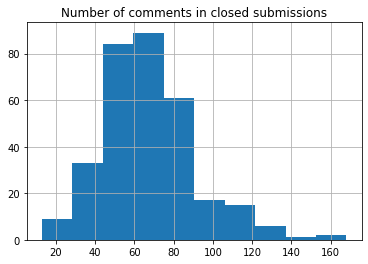

In [169]:
com = df[(df['status']=='closed') & (df['review']=='REVIEW')]['comments'].hist()
com.set_title("Number of comments in closed submissions")

In [170]:
df[(df['status']=='closed') & (df['review']=='REVIEW')]['comments'].mean()

67.44794952681389

In [171]:
df[(df['status']=='closed') & (df['review']=='REVIEW')]['comments'].median()

65.0

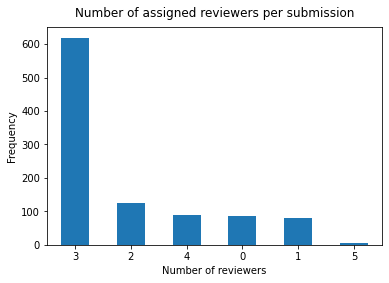

In [178]:
df['reviewers'].value_counts().plot(kind='bar',rot=0)
plt.xlabel("Number of reviewers")
plt.ylabel("Frequency")
plt.title("Number of assigned reviewers per submission", y=1.02);

# How do people feel when reviewing code?

- Small NLP Sentiment Analysis

In [179]:
from textblob import TextBlob
from wordcloud import WordCloud
import re

In [223]:
df1 = pd.read_csv('comments.csv')
df1.head()

,user,status,author_association,body,thumbs_up,thumbs_down,laugh,hooray,confused,heart,rocket,eyes
0,whedon,closed,COLLABORATOR,:wave: This repository is only for review issu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,whedon,closed,COLLABORATOR,"Hello human, I'm @whedon, a robot that can hel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,whedon,closed,COLLABORATOR,Wordcount for `paper.md` is 1310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,whedon,closed,COLLABORATOR,```\nSoftware report (experimental):\n\ngithub...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,whedon,closed,COLLABORATOR,```\nReference check summary (note 'MISSING' D...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
len(df1)

25393

In [225]:
# Exclude all comments by @whedon
df1 = df1[(df1['user']!='whedon')]

In [226]:
len(df1)

16245

In [227]:
# Exclude all comments where @whedon is tagged
df1 = df1[~(df1['body'].str.contains('@whedon'))]

In [228]:
len(df1)

11739

In [229]:
# Clean the text

def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # removes @mentiones
    text = re.sub(r'https:?\/\/\S+', '', text) # removes hyper links
    text = re.sub(r'\n', ' ', text) # new line to space
    return text

df1['body'] = df1['body'].apply(cleanTxt)

In [230]:
# Get subjectivity and polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df1['subjectivity'] = df1['body'].apply(getSubjectivity)
df1['polarity'] = df1['body'].apply(getPolarity)

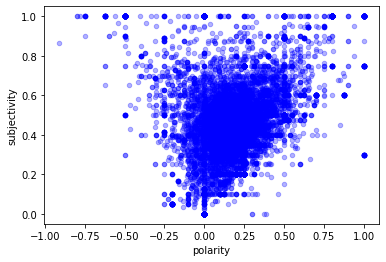

In [246]:
pt = df1.plot.scatter(x='polarity', y='subjectivity',c='Blue', alpha=0.3)

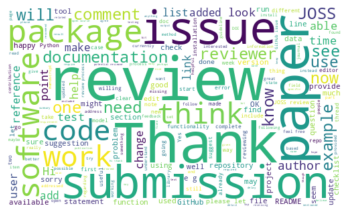

In [249]:
# Word cloud

all_words = ' '.join( [txt for txt in df1['body']])

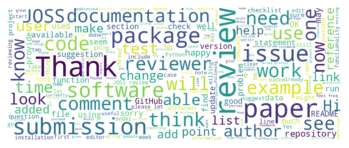

In [268]:
word_cloud = WordCloud(
    background_color='white', width=1000, height=400, random_state=15, max_font_size=90).generate(
    all_words)

plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [232]:
# Compute negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df1['analysis'] = df1['polarity'].apply(getAnalysis)

In [250]:
df1['analysis'].value_counts()

Positive    8230
Neutral     2158
Negative    1351
Name: analysis, dtype: int64

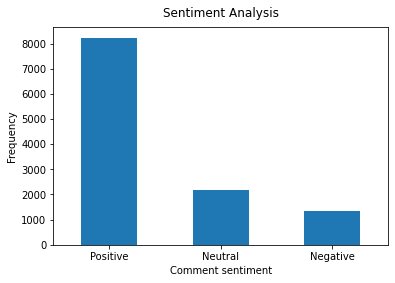

In [233]:
df1['analysis'].value_counts().plot(kind='bar',rot=0)
plt.xlabel("Comment sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Analysis", y=1.02);

Text(0.5, 1.0, 'Polarity scores')

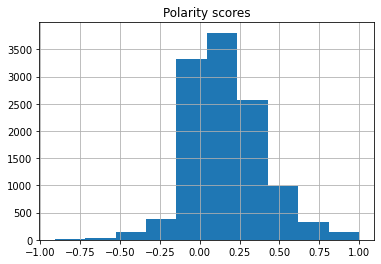

In [234]:
p = df1['polarity'].hist()
p.set_title("Polarity scores")

In [237]:
# Print most negative

sorted_df = df1.sort_values(by=['polarity'], ascending='False')
i = 0
for index, a in sorted_df.iterrows():
    if(a['analysis'] == 'Negative'):
        i += 1
        print(str(i)+ ') '+ a['user'] + ': ' + a['body'])
        print()
    if i == 10:
        break

1) danielskatz: This may have just been very bad timing

2) SteveMacenski: Hi, just wanted to touch base on this - any progress?

3) tobiasschoch: I moved the LICENSE file from inst/ to the base directory. I added a tab in front of 'index: 1' in paper.md. 

 ![missing_image](I meant was [this example]( I was indeed somewhat imprecise, sorry for this!

 * Zenodo: <5281/zenodo.5070324](s `v.1.1.1` (as stated in the submission): <

6) simonom:  I have completed my review, but my invitation to review has expired so I can't check off the checklist :(

7) pmeier:  Here you go: [10.5281/zenodo.3965784]( 

8) Kevin-Mattheus-Moerman:    this sounds like your :tea: (cup of tea), however you are both handling lots of submissions. I'll label this as waitlisted for now but let me know if you think you can take it on. 

 ```liography: [paper.bib] -> bibliography: paper.bibfigure:

 0) sgrieve:  I'm afraid I don't have any capacity this month. Apologies!



In [241]:
# Print most positive

sorted_df = df1.sort_values(by=['polarity'])
i = 0
for index, a in sorted_df.iterrows():
    if(a['polarity'] == 1):
        i += 1
        print(str(i)+ ') '+ a['user'] + ': ' + a['body'])
        print()
    if i == 10:
        break

1) sap218:  Yep! I can review! (if you could send me a set of reviewer guidelines to follow - that would be great!) 

2) xuanxu:  : Great! Thank you both!

3) bradkav:  I'm also now happy to recommend `sntools` for publication. Well done ! 

4) benjaminrose:  I recommend `sntools` for publication in JOSS. , great work!

5) ejolly: Hey !! I'm happy to review too!

6) neuromusic: Changes look great!

7) Yurlungur: Perfect!

8) ethanwhite: I concur with . Great work ! All of my concerns have been addressed and I support accepted of this paper.

 Thank you. By the way, I also corrected the DOI as whedon suggested. Best regards.

10) crvernon: Excellent !  I'll sign you up.  Thank you! 



# Emojis summary

In [253]:
emojis = df1[["thumbs_up","thumbs_down","laugh","hooray","confused","heart","rocket", "eyes"]]

In [254]:
emojis = emojis.sum(axis=0, skipna=True)

In [255]:
emojis

thumbs_up      2590.0
thumbs_down       0.0
laugh            35.0
hooray          333.0
confused          2.0
heart           187.0
rocket          112.0
eyes             30.0
dtype: float64

In [256]:
type(emojis)

pandas.core.series.Series

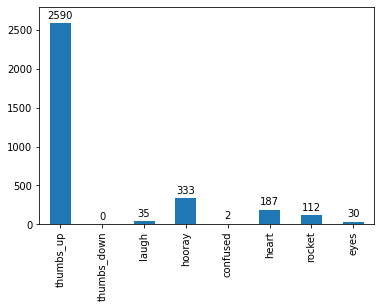

In [266]:
p = emojis.plot.bar()
p.set_ylim(0, 2800)
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 8),
                   textcoords='offset points')